In [1]:
import numpy as np
from binarytree import Node
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import random

In [2]:
class CustomDecisionTreeClassifier:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def _split_list_on_value_change(self, lst):
        results = []
        current_group = [lst[0]]
        for i in range(1, len(lst)):
            if lst[i] != lst[i - 1]:
                results.append((current_group[:], lst[i:]))
            current_group.append(lst[i])
        return results

    def _gini(self, lst):
        prob_p = np.sum(np.array(lst) == 1) / len(lst)
        prob_n = np.sum(np.array(lst) == 0) / len(lst)
        gini = prob_p ** 2 + prob_n ** 2
        return gini

    def _gini_impurity_continuous(self, y_lst):
        splited_y = self._split_list_on_value_change(y_lst)
        gini_impurity_lst = []
        for pair in splited_y:
            gini_f = self._gini(pair[0])
            gini_s = self._gini(pair[1])
            gini_impurity_f = 1 - gini_f
            gini_impurity_s = 1 - gini_s
            weighted_gini_impurited = len(pair[0]) / (len(pair[0]) + len(pair[1])) * gini_impurity_f + \
                                      len(pair[1]) / (len(pair[0]) + len(pair[1])) * gini_impurity_s
            gini_impurity_lst.append((weighted_gini_impurited, pair))
        return min(gini_impurity_lst, key=lambda x: x[0])

    def _gini_impurity_categorical(self, x_i_list, y_lst):
        arr = np.concatenate((x_i_list.reshape(-1, 1), y_lst[:, np.newaxis]), axis=1)
        change_indices = np.where(arr[:-1, 0] != arr[1:, 0])[0] + 1
        split_arrays = np.split(arr, change_indices)
        gini_f = self._gini(split_arrays[0][:, 1])
        gini_impurity_f = 1 - gini_f
        if len(split_arrays) == 2:
            gini_s = self._gini(split_arrays[1][:, 1])
            gini_impurity_s = 1 - gini_s
        else:
            return (gini_impurity_f, (split_arrays[0][:, 1]))
        weighted_gini_impurited = len(split_arrays[0][:, 1]) / (len(split_arrays[0][:, 1]) + len(split_arrays[1][:, 1])) * gini_impurity_f \
        + len(split_arrays[1][:, 1]) / (len(split_arrays[0][:, 1]) + len(split_arrays[1][:, 1])) * gini_impurity_s
        return (weighted_gini_impurited, (split_arrays[0][:, 1], split_arrays[1][:, 1]))

    def _built_bst(self, arr, depth=0):
        if len(arr) == 0 \
        or len(list(set(arr.T[-1]))) == 1 \
        or (self.max_depth is not None and depth > self.max_depth) \
        or arr.shape[0] < self.min_samples_split:
            return None

        gini_impurity_all_features = []
        for i in range(arr.shape[1] - 1):
            sorted_indices = np.argsort(arr[:, i])
            sorted_array = arr[sorted_indices]
            if len(np.unique(sorted_array[:, i])) <= 2:
                gini_impurity_cortege = self._gini_impurity_categorical(sorted_array[:, i], sorted_array.T[-1])
                gini_impurity_all_features.append(gini_impurity_cortege)
            else:
                gini_impurity_cortege = self._gini_impurity_continuous(sorted_array.T[-1])
                gini_impurity_all_features.append(gini_impurity_cortege)
        best_split_index = np.argmin([x[0] for x in gini_impurity_all_features])
        best_split = gini_impurity_all_features[best_split_index][1]
        sorted_indices = np.argsort(arr[:, best_split_index])
        sorted_array = arr[sorted_indices]
        if isinstance(best_split, tuple):
            spliter = (sorted_array[len(best_split[0]) - 1, best_split_index] + sorted_array[len(best_split[0]), best_split_index]) / 2
            if spliter == sorted_array[len(best_split[0]) - 1, best_split_index]:
                if sorted_array[sorted_array[:, best_split_index] > spliter, best_split_index].shape[0] != 0:
                    new_spliter = np.min(sorted_array[sorted_array[:, best_split_index] > spliter, best_split_index])
                else:
                    new_spliter = np.max(sorted_array[sorted_array[:, best_split_index] < spliter, best_split_index])
                spliter = (spliter + new_spliter) / 2
            
            node = Node(f"{best_split_index} {spliter}")

            mask = arr[:, best_split_index] < spliter
            left_arr = arr[mask]
            right_arr = arr[~mask]

            node.left = self._built_bst(left_arr, depth + 1)
            node.right = self._built_bst(right_arr, depth + 1)
        else:
            return None
            
        return node

    def _add_predict_to_nodes(self, node, arr):
        col_split = node.value.split(" ")
        mask = arr[:, int(col_split[0])] < float(col_split[1])
        left_arr = arr[mask]
        right_arr = arr[~mask]
        left_count_class_0 = np.sum(left_arr[:, -1] == 0)
        left_count_class_1 = np.sum(left_arr[:, -1] == 1)
        right_count_class_0 = np.sum(right_arr[:, -1] == 0)
        right_count_class_1 = np.sum(right_arr[:, -1] == 1)
        if node.left is not None:
            self._add_predict_to_nodes(node.left, left_arr)
        if node.right is not None:
            self._add_predict_to_nodes(node.right, right_arr)
        if node.left is None:
            node.left = Node(1 if left_count_class_1 > left_count_class_0 else 0)
        if node.right is None:
            node.right = Node(1 if right_count_class_1 > right_count_class_0 else 0)

    def fit(self, X, y):
        X = X.values
        y = y.values
        arr = np.concatenate((X, y[:, np.newaxis]), axis=1)
        self.bst = self._built_bst(arr)
        self._add_predict_to_nodes(self.bst, arr)

    def _predict(self, x, node):
        if not isinstance(node.value, int):
            col_split = node.value.split(" ")
            if x[int(col_split[0])] < float(col_split[1]):
                if not isinstance(node.left.value, int):
                    return self._predict(x, node.left)
                else:
                    return node.left.value
            else:
                if not isinstance(node.right.value, int):
                    return self._predict(x, node.right)
                else:
                    return node.right.value
            
    def predict(self, X):
        y_pred = []
        X = X.values
        for x_i in X:
            y_pred.append(self._predict(x_i, self.bst))
        return y_pred

In [22]:
class CustomRandomForestClassifier:
    def __init__(self, n_estimators=100, max_samples=0.7, max_depth=None, min_samples_split=2):
        self.max_samples = max_samples
        self.dt_lst = []
        for i in range(n_estimators):
            self.dt_lst.append(CustomDecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split))

    def fit(self, X, y):
        X_copy = X.values

        example_lists = []
        for _ in range(len(self.dt_lst)):
            new_list = random.sample(range(X_copy.shape[0]), int(X_copy.shape[0] * self.max_samples))
            example_lists.append(new_list)

        idx = 0
        while idx < len(self.dt_lst):
            self.dt_lst[idx].fit(X.iloc[example_lists[idx]], y.iloc[example_lists[idx]])
            idx += 1

    def predict(self, X):
        idx = 0
        y_pred = []
        while idx < len(self.dt_lst):
            y_pred.append(self.dt_lst[idx].predict(X))
            idx += 1

        y_pred_f = []
        for i in range(np.array(y_pred).shape[1]):
            count_ones = np.count_nonzero(np.array(y_pred).T[i] == 1)
            count_zeros = np.count_nonzero(np.array(y_pred).T[i] == 0)
            if count_ones >= count_zeros:
                y_pred_f.append(1)
            else:
                y_pred_f.append(0)
        return y_pred_f

In [4]:
def distplot(df, numeric_columns):
    """
    Draws a distplot for all numeric columns in the df dataframe.
    
    Argument:
    df -- python pandas dataframe
    numeric_columns -- list of columns of dataframe df whose values are of type int or float
    """
    num_col_drop_price = numeric_columns.drop('label', axis=1, inplace=False).columns
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(40, 70))
    for ax, column in zip(axes.flatten(), num_col_drop_price):
        sns.histplot(df[column].dropna(), ax=ax, color='darkred', kde=True)
        ax.set_title(column, fontsize=43)
        ax.tick_params(axis='both', which='major', labelsize=35)
        ax.tick_params(axis='both', which='minor', labelsize=35)
        ax.set_xlabel('')
    fig.tight_layout(rect = [0, 0.03, 1, 0.95])

In [5]:
data_df = pd.read_csv("./data/Credit_card.csv")
labels_df = pd.read_csv("./data/Credit_card_label.csv")
data_df, labels_df

(       Ind_ID GENDER Car_Owner Propert_Owner  CHILDREN  Annual_income  \
 0     5008827      M         Y             Y         0       180000.0   
 1     5009744      F         Y             N         0       315000.0   
 2     5009746      F         Y             N         0       315000.0   
 3     5009749      F         Y             N         0            NaN   
 4     5009752      F         Y             N         0       315000.0   
 ...       ...    ...       ...           ...       ...            ...   
 1543  5028645      F         N             Y         0            NaN   
 1544  5023655      F         N             N         0       225000.0   
 1545  5115992      M         Y             Y         2       180000.0   
 1546  5118219      M         Y             N         0       270000.0   
 1547  5053790      F         Y             Y         0       225000.0   
 
                Type_Income                      EDUCATION  \
 0                Pensioner               Higher

In [6]:
merged_df = data_df.merge(labels_df, on="Ind_ID")
merged_df.drop("Ind_ID", axis=1, inplace=True)
merged_df

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
0,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1
1,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
2,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1
3,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
4,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,F,N,Y,0,NaN,Commercial associate,Higher education,Married,House / apartment,-11957.0,-2182,1,0,0,0,Managers,2,0
1544,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,1,0,0,0,Accountants,1,0
1545,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,1,0,0,0,Managers,4,0
1546,M,Y,N,0,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-15292.0,-645,1,1,1,0,Drivers,2,0


Ind_ID: Client ID

Gender: Gender information

Car_owner: Having car or not

Propert_owner: Having property or not

Children: Count of children

Annual_income: Annual income

Type_Income: Income type

Education: Education level

Marital_status: Marital_status

Housing_type: Living style

Birthday_count: Use backward count from current day (0), -1 means yesterday.

Employed_days: Start date of employment. Use backward count from current day (0). Positive value means, individual is currently unemployed.

Mobile_phone: Any mobile phone

Work_phone: Any work phone

Phone: Any phone number

EMAIL_ID: Any email ID

Type_Occupation: Occupation

Family_Members: Family size

Another data set (Credit_card_label.csv) contains two key pieces of information

ID: The joining key between application data and credit status data, same is Ind_ID

Label: 0 is application approved and 1 is application rejected. 

In [7]:
merged_df.columns

Index(['GENDER', 'Car_Owner', 'Propert_Owner', 'CHILDREN', 'Annual_income',
       'Type_Income', 'EDUCATION', 'Marital_status', 'Housing_type',
       'Birthday_count', 'Employed_days', 'Mobile_phone', 'Work_Phone',
       'Phone', 'EMAIL_ID', 'Type_Occupation', 'Family_Members', 'label'],
      dtype='object')

In [8]:
for col in merged_df.columns:
    print(merged_df[col].value_counts())
    print("="*50)

GENDER
F    973
M    568
Name: count, dtype: int64
Car_Owner
N    924
Y    624
Name: count, dtype: int64
Propert_Owner
Y    1010
N     538
Name: count, dtype: int64
CHILDREN
0     1091
1      305
2      134
3       16
4        1
14       1
Name: count, dtype: int64
Annual_income
135000.0    170
112500.0    144
180000.0    137
157500.0    125
225000.0    119
           ... 
119250.0      1
328500.0      1
787500.0      1
594000.0      1
167400.0      1
Name: count, Length: 115, dtype: int64
Type_Income
Working                 798
Commercial associate    365
Pensioner               269
State servant           116
Name: count, dtype: int64
EDUCATION
Secondary / secondary special    1031
Higher education                  426
Incomplete higher                  68
Lower secondary                    21
Academic degree                     2
Name: count, dtype: int64
Marital_status
Married                 1049
Single / not married     227
Civil marriage           101
Separated                 9

In [9]:
merged_df.drop("Mobile_phone", axis=1, inplace=True)

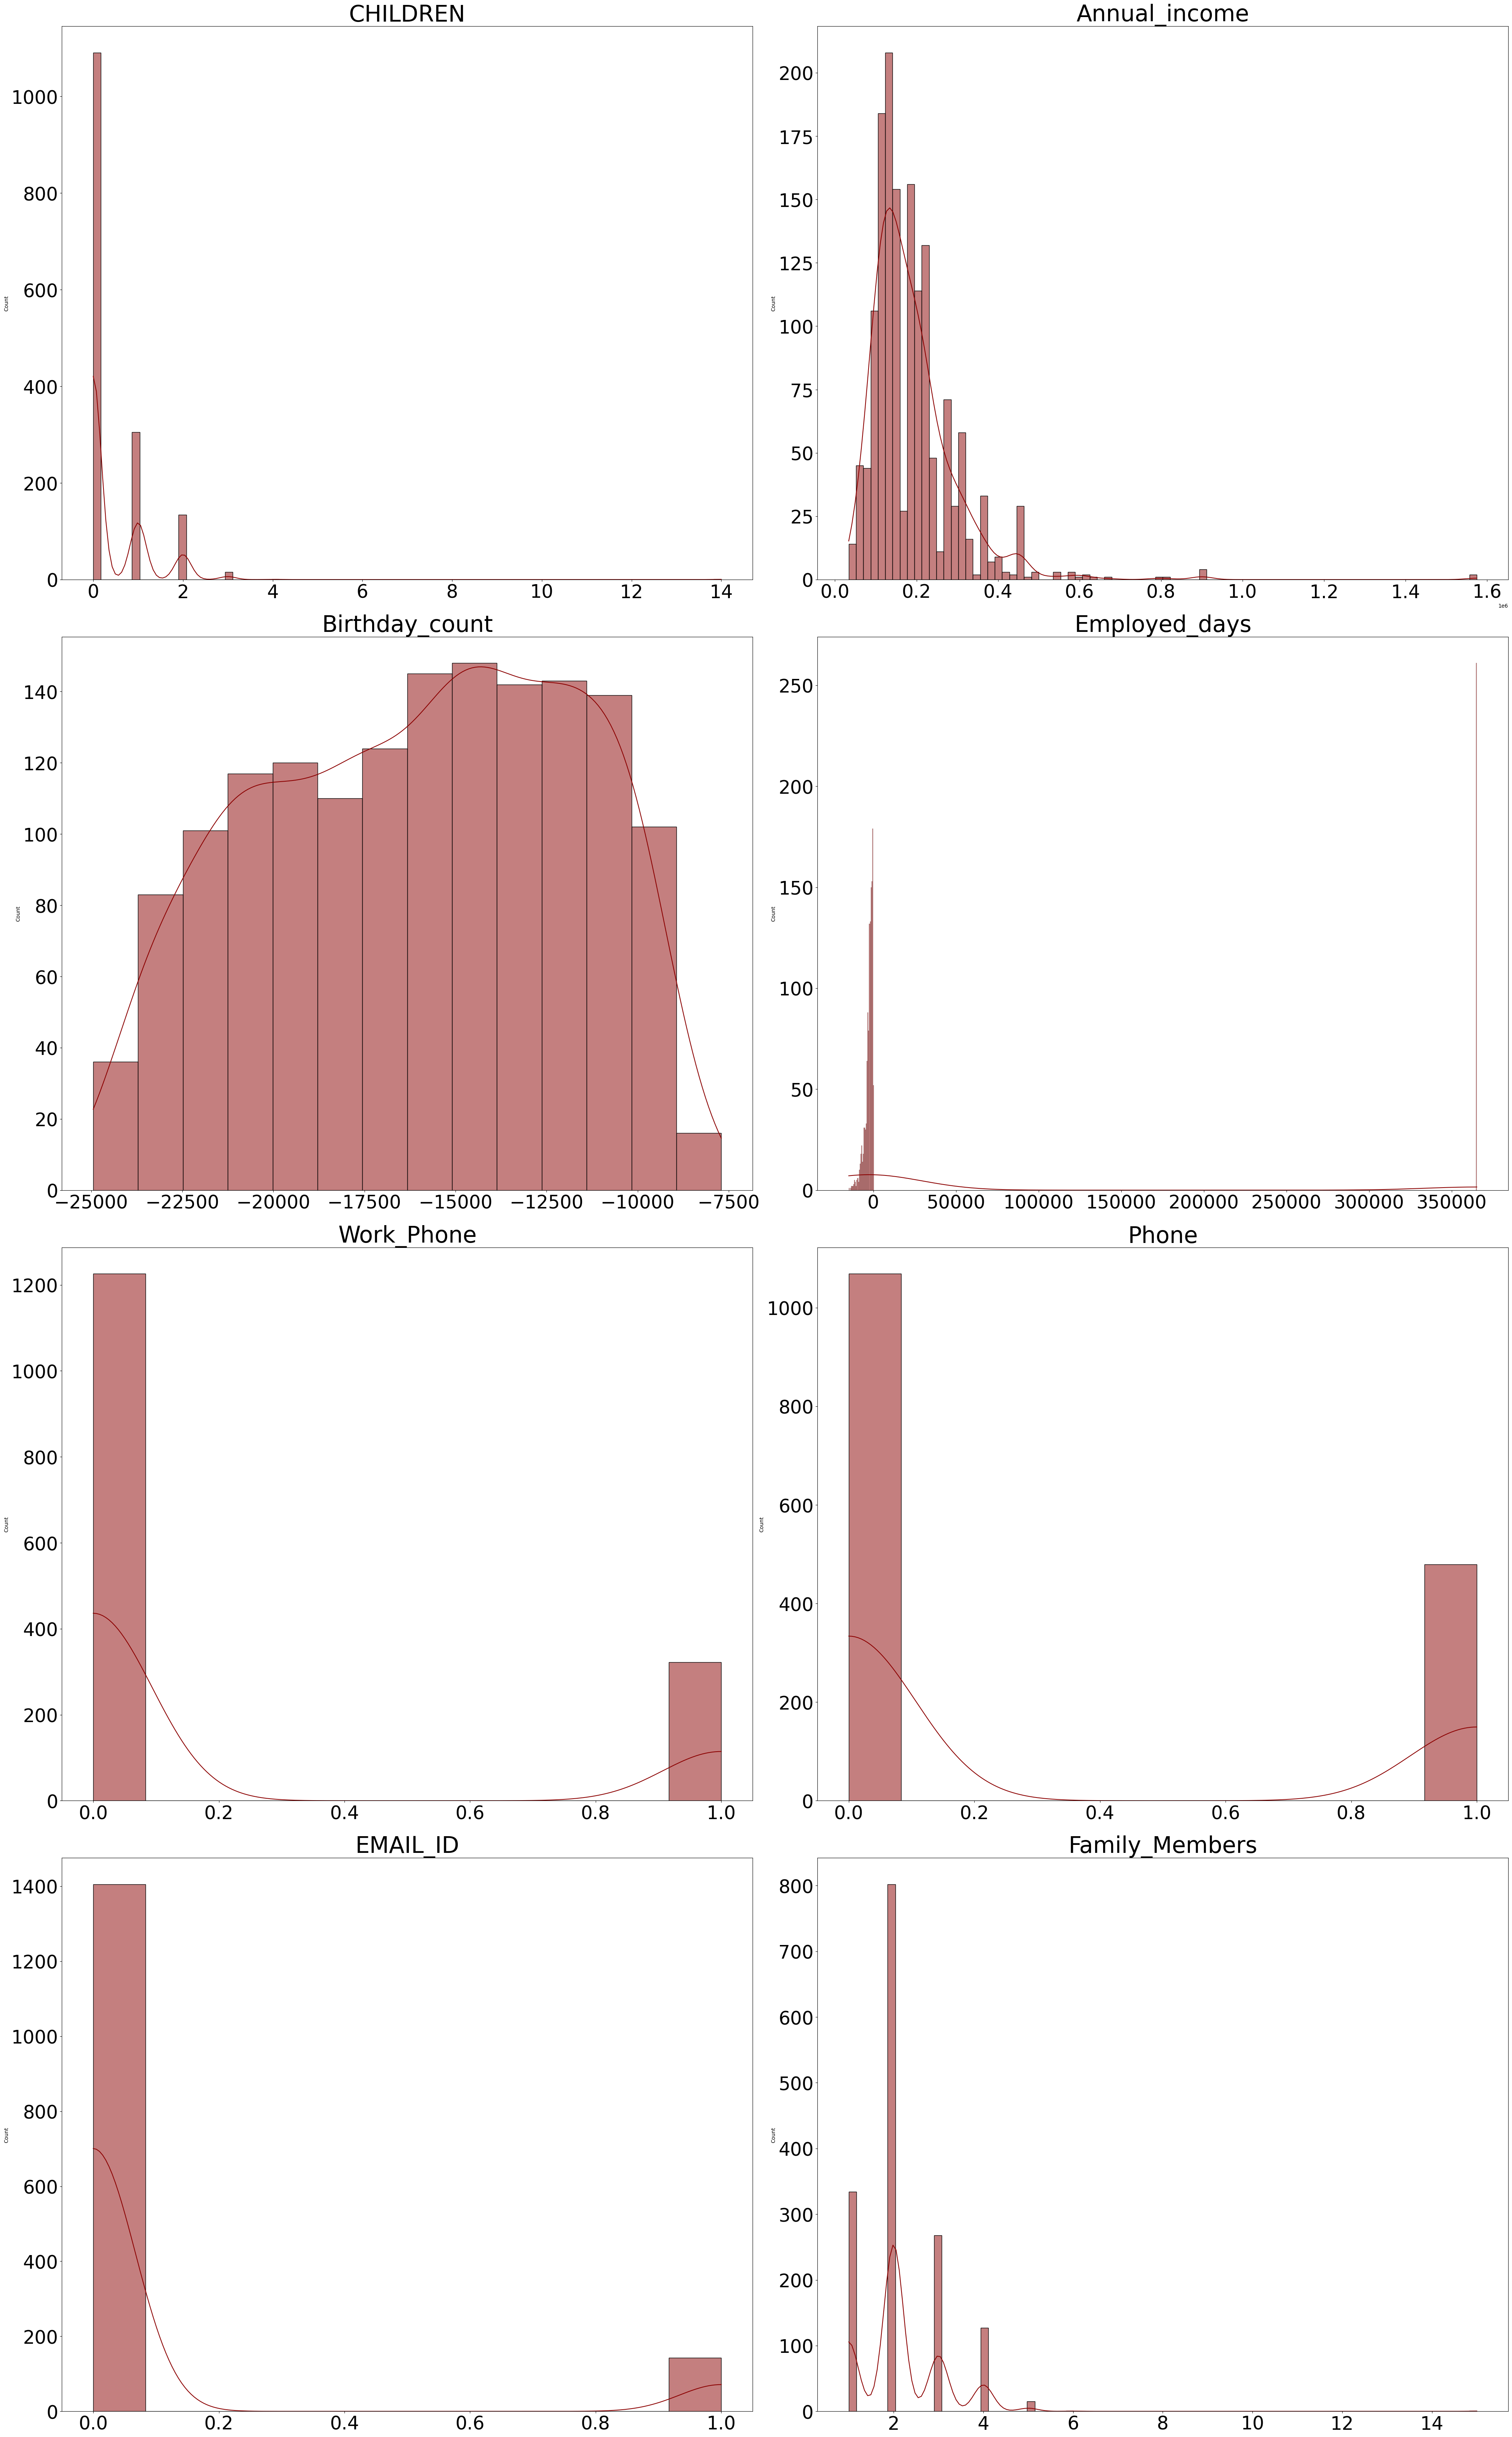

In [10]:
numeric_columns = merged_df.select_dtypes(include=['int', 'float'])
distplot(merged_df, numeric_columns)

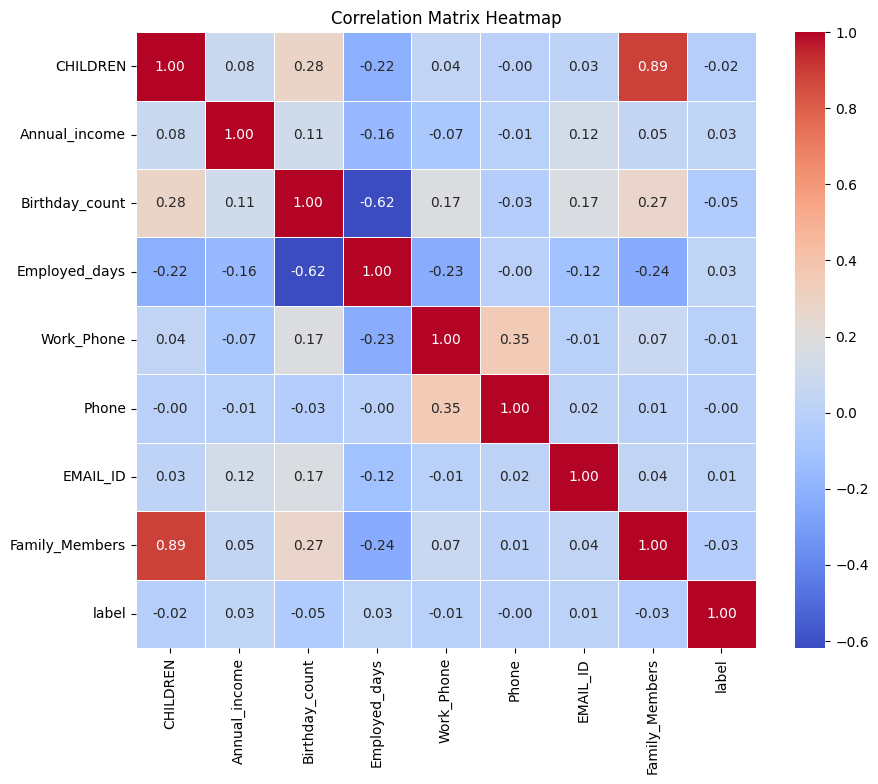

In [11]:
correlation_matrix = merged_df[numeric_columns.columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [12]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1548 entries, 0 to 1547
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GENDER           1541 non-null   object 
 1   Car_Owner        1548 non-null   object 
 2   Propert_Owner    1548 non-null   object 
 3   CHILDREN         1548 non-null   int64  
 4   Annual_income    1525 non-null   float64
 5   Type_Income      1548 non-null   object 
 6   EDUCATION        1548 non-null   object 
 7   Marital_status   1548 non-null   object 
 8   Housing_type     1548 non-null   object 
 9   Birthday_count   1526 non-null   float64
 10  Employed_days    1548 non-null   int64  
 11  Work_Phone       1548 non-null   int64  
 12  Phone            1548 non-null   int64  
 13  EMAIL_ID         1548 non-null   int64  
 14  Type_Occupation  1060 non-null   object 
 15  Family_Members   1548 non-null   int64  
 16  label            1548 non-null   int64  
dtypes: float64(2),

In [13]:
merged_df.dropna(inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1025 entries, 8 to 1546
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GENDER           1025 non-null   object 
 1   Car_Owner        1025 non-null   object 
 2   Propert_Owner    1025 non-null   object 
 3   CHILDREN         1025 non-null   int64  
 4   Annual_income    1025 non-null   float64
 5   Type_Income      1025 non-null   object 
 6   EDUCATION        1025 non-null   object 
 7   Marital_status   1025 non-null   object 
 8   Housing_type     1025 non-null   object 
 9   Birthday_count   1025 non-null   float64
 10  Employed_days    1025 non-null   int64  
 11  Work_Phone       1025 non-null   int64  
 12  Phone            1025 non-null   int64  
 13  EMAIL_ID         1025 non-null   int64  
 14  Type_Occupation  1025 non-null   object 
 15  Family_Members   1025 non-null   int64  
 16  label            1025 non-null   int64  
dtypes: float64(2), int6

In [14]:
merged_df

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
8,M,Y,Y,1,450000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18173.0,-678,0,1,1,Core staff,3,1
9,M,Y,Y,1,450000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-18173.0,-678,0,1,1,Core staff,3,1
10,M,Y,Y,1,450000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-18173.0,-678,0,1,1,Core staff,1,1
11,F,Y,Y,0,90000.0,Working,Secondary / secondary special,Married,House / apartment,-18950.0,-1002,1,1,0,Cooking staff,2,1
13,F,Y,Y,0,90000.0,Working,Secondary / secondary special,Married,House / apartment,-18950.0,-1002,1,1,0,Cooking staff,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,F,Y,Y,1,144000.0,Working,Higher education,Married,House / apartment,-12903.0,-2924,0,0,0,Accountants,3,0
1542,M,Y,N,1,360000.0,State servant,Secondary / secondary special,Married,House / apartment,-11294.0,-3536,0,1,0,Drivers,3,0
1544,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,0,0,0,Accountants,1,0
1545,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,0,0,0,Managers,4,0


In [15]:
merged_df['GENDER'] = merged_df['GENDER'].map({'M': 1, 'F': 0}).astype(int)
merged_df['Car_Owner'] = merged_df['Car_Owner'].map({'Y': 1, 'N': 0}).astype(int)
merged_df['Propert_Owner'] = merged_df['Propert_Owner'].map({'Y': 1, 'N': 0}).astype(int)
merged_df

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,label
8,1,1,1,1,450000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18173.0,-678,0,1,1,Core staff,3,1
9,1,1,1,1,450000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-18173.0,-678,0,1,1,Core staff,3,1
10,1,1,1,1,450000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-18173.0,-678,0,1,1,Core staff,1,1
11,0,1,1,0,90000.0,Working,Secondary / secondary special,Married,House / apartment,-18950.0,-1002,1,1,0,Cooking staff,2,1
13,0,1,1,0,90000.0,Working,Secondary / secondary special,Married,House / apartment,-18950.0,-1002,1,1,0,Cooking staff,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,0,1,1,1,144000.0,Working,Higher education,Married,House / apartment,-12903.0,-2924,0,0,0,Accountants,3,0
1542,1,1,0,1,360000.0,State servant,Secondary / secondary special,Married,House / apartment,-11294.0,-3536,0,1,0,Drivers,3,0
1544,0,0,0,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,0,0,0,Accountants,1,0
1545,1,1,1,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,0,0,0,Managers,4,0


In [16]:
df_encoded = pd.get_dummies(merged_df)
bool_columns = df_encoded.select_dtypes(include=['bool'])
df_encoded[bool_columns.columns] = df_encoded[bool_columns.columns].astype(int)
df_encoded

,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Birthday_count,Employed_days,Work_Phone,Phone,EMAIL_ID,...,Type_Occupation_Laborers,Type_Occupation_Low-skill Laborers,Type_Occupation_Managers,Type_Occupation_Medicine staff,Type_Occupation_Private service staff,Type_Occupation_Realty agents,Type_Occupation_Sales staff,Type_Occupation_Secretaries,Type_Occupation_Security staff,Type_Occupation_Waiters/barmen staff
8,1,1,1,1,450000.0,-18173.0,-678,0,1,1,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,450000.0,-18173.0,-678,0,1,1,...,0,0,0,0,0,0,0,0,0,0
10,1,1,1,1,450000.0,-18173.0,-678,0,1,1,...,0,0,0,0,0,0,0,0,0,0
11,0,1,1,0,90000.0,-18950.0,-1002,1,1,0,...,0,0,0,0,0,0,0,0,0,0
13,0,1,1,0,90000.0,-18950.0,-1002,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,0,1,1,1,144000.0,-12903.0,-2924,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1542,1,1,0,1,360000.0,-11294.0,-3536,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1544,0,0,0,0,225000.0,-10229.0,-1209,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1545,1,1,1,2,180000.0,-13174.0,-2477,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [17]:
X = df_encoded.drop(columns=['label'])
y = df_encoded['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
custom_dt = CustomDecisionTreeClassifier()
custom_dt.fit(X_train, y_train)
y_pred = custom_dt.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1

0.5617977528089888

In [19]:
clf = DecisionTreeClassifier(random_state=94)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1

0.5

In [28]:
clf_rf = CustomRandomForestClassifier(n_estimators=150, max_samples=0.7)
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1

0.6

In [31]:
clf_rf = RandomForestClassifier(random_state=94)
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1

0.6

In [36]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
grid_search = GridSearchCV(clf_rf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_f1 = grid_search.best_score_
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred = clf_rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("The best hyperparameters:", best_params)
print("F1:", f1)

The best hyperparameters: {'max_samples': 1.0, 'n_estimators': 10}
F1: 0.6
